## Questions are answered at very bottom of file, questions marked with markdown cells

In [34]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

In [35]:
# Define filepath
filepath = 'C:/Users/Lumin/geospatial-data-science/labs/lab4/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B7.tif', 'C:/Users/Lumin/geospatial-data-science/labs/lab4/landsat\\rgb.tif']


In [36]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1)

In [37]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


In [38]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [39]:
# Find format
src.driver

'GTiff'

In [40]:
# Find pixel size
src.transform[0]

30.0

In [41]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

In [42]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


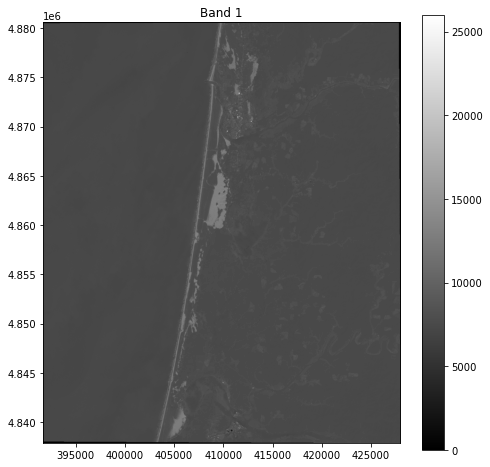

In [43]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

In [44]:
# Find number of columns and rows in array
band_1.shape

(1422, 1208)

In [45]:
# Find total number of pixels in array
band_1.size

1717776

In [46]:
# Find maximum value in array
band_1.max()

25983

In [47]:
# Find datatype
band_1.dtype

dtype('uint16')

In [48]:
# Find maximum possible value in array
2**16

65536

In [49]:
# Find file size (in MB)
band_1.nbytes / 1000000

3.435552

In [50]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

all_bands.shape

In [51]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [52]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

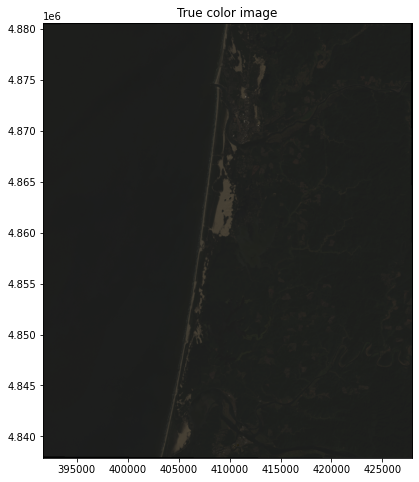

In [57]:

# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()


In [54]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

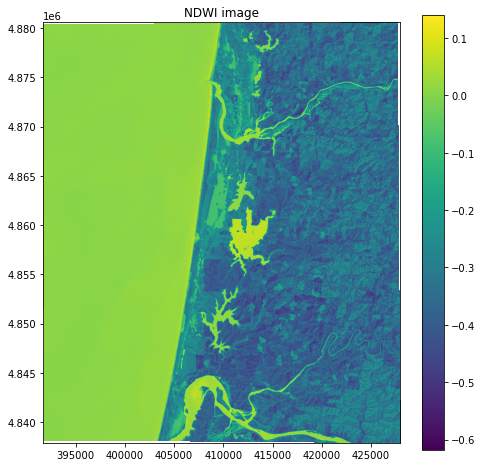

In [55]:
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [56]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [ ]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

In [59]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [60]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 233, latitude: 99, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-05 17:55:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [61]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


In [62]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

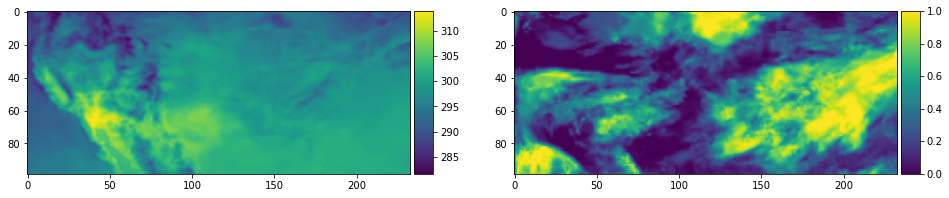

In [63]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [64]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

C:\Users\Lumin\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\Lumin\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [89]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [75]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.25 F


Text(0, 0.5, 'Cloud cover (%)')

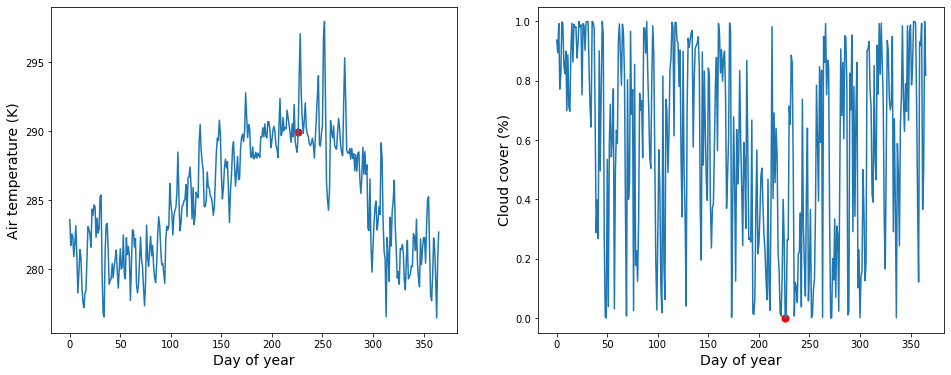

In [67]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

In [68]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.55 F


In [78]:
mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean cloud cover in Florence in 2020 = 58.76 %


In [70]:
days = np.sum(florence_weather['tcc'] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 61 days with less than 20% cloud cover in 2020


In [82]:
# HINT use argmax() or argmin()
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)

## Question 1 Answers

In [106]:
eugene_weather = xds_daily.sel(latitude=44.0603335290, longitude=-123.1025586, method='nearest')
fahrenheit1 = (florence_weather['t2m'][30].values - 273.15) * 9/5 + 32
fahrenheit2 = (eugene_weather['t2m'][45].values - 273.15) * 9/5 + 32
print("1a) ",'Cloud cover in Florence on Jan 31, 2020 = %.2f %%' % (florence_weather['tcc'][30].values * 100))
print("   ",'Air temperature in Florence on Jan 31, 2020 = %.2f F' % (fahrenheit1))
print("1b) ",'Cloud cover in Eugene on Feb 15, 2020 = %.2f %%' % (eugene_weather['tcc'][45].values * 100))
print("   ",'Air temperature in Eugene on Feb 15, 2020 = %.2f F' % (fahrenheit2))


1a)  Cloud cover in Florence on Jan 31, 2020 = 99.98 %
    Air temperature in Florence on Jan 31, 2020 = 53.82 F
1b)  Cloud cover in Eugene on Feb 15, 2020 = 99.99 %
    Air temperature in Eugene on Feb 15, 2020 = 42.00 F


C:\Users\Lumin\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\Lumin\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


## Question 2 Answers + code Below

In [120]:
t2m_mean = xds_daily['t2m'].mean(dim = 'time')
hottest = t2m_mean.argmax()
print(hottest)
heatindex = np.unravel_index(hottest, xds_daily['t2m'].shape)
print(heatindex)
(t2m_mean[81,55])


<xarray.DataArray 't2m' ()>
array(18928, dtype=int64)
(0, 81, 55)


<xarray.DataArray 't2m' ()>
array(299.2989, dtype=float32)
Coordinates:
    longitude  float32 -111.2
    latitude   float32 28.99

In [131]:
print("2a) Hottest mean is close to somewhere called Hermosillo Sorona, in Mexico(?)(28.99, -111.2)")

2a) Hottest mean is close to somewhere called Hermosillo Sorona, in Mexico(?)(28.99, -111.2)


In [118]:
coldest = t2m_mean.argmin()
print(coldest)
t2m_mean[21,61]

<xarray.DataArray 't2m' ()>
array(4954, dtype=int64)


<xarray.DataArray 't2m' ()>
array(271.5829, dtype=float32)
Coordinates:
    longitude  float32 -109.8
    latitude   float32 43.99

In [174]:
print('2b) Coldest place is a town called Cody, Wyoming (43.99, -109.8)🥶')

2b) Coldest place is a town called Cody, Wyoming (43.99, -109.8)🥶


In [128]:
xds_ymean = xds.resample(time = '1y').mean() * 100
tcc_mean = xds_daily['tcc'].mean(dim ='time')
tcc_mean_argmax = tcc_mean.argmax()
print(tcc_mean_argmax)
tcc_mean_argmin = tcc_mean.argmin()
print(tcc_mean_argmin)

<xarray.DataArray 'tcc' ()>
array(0, dtype=int64)
<xarray.DataArray 'tcc' ()>
array(16584, dtype=int64)


In [129]:
tcc_mean_minindex = np.unravel_index(tcc_mean_argmin, xds_daily['tcc'].shape)
tcc_mean_minindex

(0, 71, 41)

In [130]:
(tcc_mean[71, 41])

<xarray.DataArray 'tcc' ()>
array(0.16893195, dtype=float32)
Coordinates:
    longitude  float32 -114.8
    latitude   float32 31.49

In [133]:
print('2c) The least cloudy spot looks like somewhere in the gulf of Mexico, with roughly a cloud cover value of 0.169')

2c) The least cloudy spot looks like somewhere in the gulf of Mexico, with roughly a cloud cover value of 0.169


In [136]:
mean_tcc = np.mean(xds_daily['tcc'], axis = 0 )
#mean_tcc
(mean_tcc[0 , 0])

<xarray.DataArray 'tcc' ()>
array(0.77146894, dtype=float32)
Coordinates:
    longitude  float32 -125.0
    latitude   float32 49.24

In [137]:
print("2d) The highest mean cloud cover is in Port Alberni, Canada (49.24, -125.0)")

2d) The highest mean cloud cover is in Port Alberni, Canada (49.24, -125.0)


In [147]:
# Get the max and the min for temps, find the area with the greatest difference
daily_max = np.max(xds_daily['t2m'], axis = 0 )
#print(daily_max)
daily_min = np.min(xds_daily['t2m'], axis = 0 )
#print(daily_min)
max_range = (daily_max - daily_min)
max_range.argmax()

# I had trouble with the code for indexing the greatest difference, I asked but could not find what was causing the 
max_range[1 , 210]


<xarray.DataArray 't2m' ()>
array(57.7585, dtype=float32)
Coordinates:
    longitude  float32 -72.5
    latitude   float32 48.99

In [148]:
print("2e) The highest range for a single location is 57.76 degrees celcius, in Girardville, in eastern Quebec")

2e) The highest range for a single location is 57.76 degrees celcius, in Girardville, in eastern Quebec


In [151]:
MAX_COLD = np.min(xds_daily['t2m'], axis = 0)
MAX_COLD_MIN = MAX_COLD.argmin()
MAX_COLD_index = np.unravel_index(MAX_COLD_MIN, xds_daily['t2m'].shape)
#print(MAX_COLD_index)
MAX_COLD [MAX_COLD_index[1],MAX_COLD_index[2]]

<xarray.DataArray 't2m' ()>
array(241.72095, dtype=float32)
Coordinates:
    longitude  float32 -111.2
    latitude   float32 48.74

In [152]:
print("2f) The single coldest place is in Whitlash Montana, at roughly -31.15 celcius")

2f) The single coldest place is in Whitlash Montana, at roughly -31.15 celcius


## Question 3 Answers + Code Below

In [165]:
#all_bands_image
all_bands_image = np.uint8((all_bands / 65536) * 255)

np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)),
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))

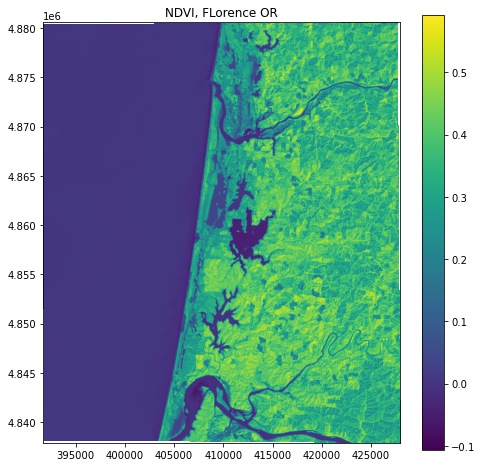

NDVI


In [169]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI, FLorence OR")
fig.colorbar(im, orientation='vertical')
plt.show()
print("NDVI")

In [172]:
infra = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3],all_bands_image[:,:,2]))

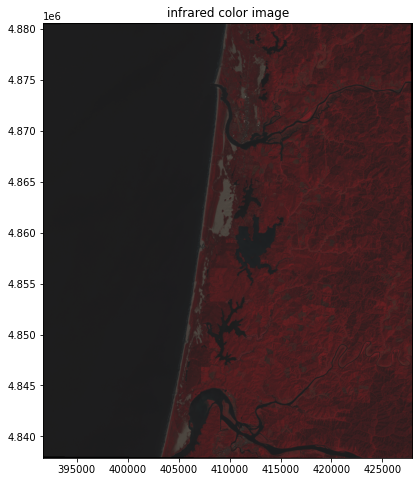

In [173]:
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(infra, extent=full_extent)
ax.set_title("infrared color image")
plt.show()